# Importing Libraries
> `OpenCV` is not used.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
#import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'Raw Image')

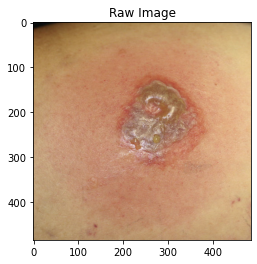

In [2]:
img = io.imread("RashData\Lyme_Positive_By_Diease\EMRash\erythema migrans42.jpg")
plt.imshow(img)
plt.title("Raw Image")

Text(0.5, 1.0, 'Resized Image')

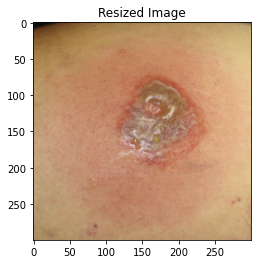

In [3]:
HEIGHT, WIDTH = 300, 300
resized_img = resize(img, (HEIGHT, WIDTH))
plt.imshow(resized_img)
plt.title("Resized Image")

# Importing the data
1. Loading the data from root directory
2. Each image is resized into `200 * 200` dimension
3. The imported image is converted into an numpy array
4. Each data is normalized

In [4]:
# Creating the dataset for processing -- Using SKIMAGE
path_root = "RashData/Train/Train_2_Cases"
data = []
categories = ["Negative", "Positive"]
flag = True
for category in categories:
    path = os.path.join(path_root, "Lyme_" + category)
    label = categories.index(category)
    
    for img in os.listdir(path):
        try:
            img_path = os.path.join(path, img)
            dis_img = io.imread(img_path)
            if flag:
                print(type(dis_img))
                flag = False
    
            image = resize(dis_img, (HEIGHT, WIDTH))
#             image = np.array(dis_img).flatten()
            data.append([image, label])
        except Exception as e:
            print("Could not add image.")

<class 'numpy.ndarray'>


# Spliting the data array into -
* Image Feature Vector(image_ds)
* Corresponding Labels(labels)

In [6]:

image_ds = np.array([obj[0][:,:,0] for obj in data])
labels = np.array([obj[1] for obj in data])
print(image_ds.shape)
#image_ds = image_ds.reshape((356, 200, 200, 1))
len(labels[labels == 1])

(357, 300, 300)


151

# Creating Train and Test Data
> Using 20 percent of data as the test data.

In [7]:
train_x, test_x, train_y, test_y = train_test_split(image_ds, labels, test_size=0.20, shuffle=True)
print("Size of training data:", train_x.shape)
print("Size of test data:", test_x.shape)
len(train_y[train_y==1])

Size of training data: (285, 300, 300)
Size of test data: (72, 300, 300)


122

# Using Support Vector Machine for Trainning:
1. The training and testing data is flattened
2. Model is defined with a `Polynomial` kernel
3. Model is trained 
4. Confusion Matrix and Classification Report is observed

In [8]:
train_x_flat = train_x.reshape((train_x.shape[0], HEIGHT * WIDTH))
test_x_flat = test_x.reshape((test_x.shape[0], HEIGHT * WIDTH))
print(train_x_flat.shape)
model_svm = SVC(kernel='poly', gamma='auto')
model_svm.fit(train_x_flat, train_y)

(285, 90000)


SVC(gamma='auto', kernel='poly')

In [9]:
pred_y = model_svm.predict(test_x_flat)
print(confusion_matrix(test_y, pred_y))
print(classification_report(test_y, pred_y))

[[43  0]
 [29  0]]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        43
           1       0.00      0.00      0.00        29

    accuracy                           0.60        72
   macro avg       0.30      0.50      0.37        72
weighted avg       0.36      0.60      0.45        72



# Using Deep Feed Forward Network to train
+ Using a fully connected network to train 
+ The network consists of two hidden layer of size `20000 * 1`
+ Finally using a output layer with `sigmoid` activation as it is binary classification
> Assuming the input images are of dimension `100 * 100`.

In [ ]:
model_dense = keras.models.Sequential([
    keras.Input(shape=(100 * 100,)),
    keras.layers.Dense(2 * 100 * 100, activation='relu'),
    keras.layers.Dense(2 * 100 * 100, activation='relu'),
    keras.layers.Dense(1)
])
model_dense.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_dense.fit(train_x_flat, train_y, batch_size=32, epochs=20,steps_per_epoch=4)

In [18]:
report = model_dense.evaluate(test_x_flat, test_y)
print(report)

3/3 [==============================] - 6s 355ms/step - loss: 6.4271 - accuracy: 0.5833
[6.427061557769775, 0.5833333134651184]


# Using CNN to train
This is executed in following steps:
1. First we rescale the training and validation data in range `[0, 1]`
2. Then we define 5 convolution layers with MaxPool layers and `relu` activation
3. Last output layer is of size 1 and using `sigmoid` activation function

In [4]:
train = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

train_ds = train.flow_from_directory("RashData/Train/Train_2_Cases", target_size=(HEIGHT, WIDTH),
                                    batch_size=10, class_mode='binary')
val_ds = validation.flow_from_directory("RashData/Validation/Validation_2_Cases", target_size=(HEIGHT, WIDTH),
                                       batch_size=10, class_mode='binary')
val_ds.class_indices
filter_size = (2, 2)
epochs = 25

Found 357 images belonging to 2 classes.
Found 87 images belonging to 2 classes.


In [11]:
model_conv_2d = keras.models.Sequential([
    keras.layers.Conv2D(32, filter_size, activation='relu', input_shape=(HEIGHT, WIDTH, 3), kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(64, filter_size, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(128, filter_size, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(256, filter_size, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(512, filter_size, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model_conv_2d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_conv_2d.fit(train_ds, steps_per_epoch=3, epochs=epochs, validation_data=val_ds)

Epoch 1/25
3/3 [==============================] - 12s 4s/step - loss: 21.3075 - accuracy: 0.5333 - val_loss: 3.4263 - val_accuracy: 0.5517
Epoch 2/25
3/3 [==============================] - 11s 4s/step - loss: 18.4594 - accuracy: 0.6667 - val_loss: 3.5513 - val_accuracy: 0.5977
Epoch 3/25
3/3 [==============================] - 13s 5s/step - loss: 51.8001 - accuracy: 0.4667 - val_loss: 4.3513 - val_accuracy: 0.4483
Epoch 4/25
3/3 [==============================] - 12s 5s/step - loss: 33.4483 - accuracy: 0.4667 - val_loss: 5.4718 - val_accuracy: 0.5862
Epoch 5/25
3/3 [==============================] - 13s 5s/step - loss: 11.9037 - accuracy: 0.4667 - val_loss: 5.2853 - val_accuracy: 0.5862
Epoch 6/25
3/3 [==============================] - 12s 5s/step - loss: 20.2673 - accuracy: 0.4333 - val_loss: 4.3390 - val_accuracy: 0.5862
Epoch 7/25
3/3 [==============================] - 12s 5s/step - loss: 6.2614 - accuracy: 0.6333 - val_loss: 3.9390 - val_accuracy: 0.5862
Epoch 8/25
3/3 [============

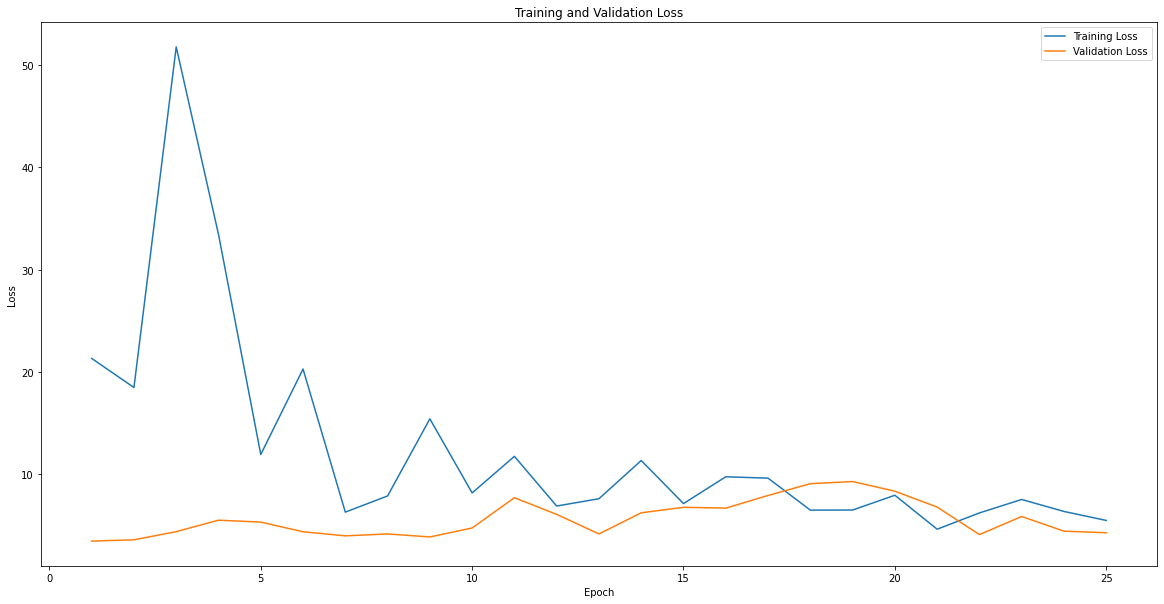

In [13]:
plt.figure(figsize=(20, 10))

epochs_range = range(1, epochs + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# train_auc = history.history['auc']
# val_auc = history.history['val_auc']

# plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, train_auc, label="Training AUC", color='b')
# plt.plot(epochs_range, val_auc, label="Validation AUC", color='r')

# plt.xlabel("Epoch")
# plt.ylabel("AUC")
# plt.title("Training and Validation AUC")
# plt.legend()

plt.show()

In [16]:
train_ds.n

357

## Using different state of the art models
+ VGG19
+ ResNet

In [8]:
DIMS_VGG = (224, 224, 3)
train_vgg = train.flow_from_directory("RashData/Train/Train_2_Cases", target_size=(DIMS_VGG[0], DIMS_VGG[1]),
                                    batch_size=10, class_mode='binary')
val_vgg = validation.flow_from_directory("RashData/Validation/Validation_2_Cases", 
                                         target_size=(DIMS_VGG[0], DIMS_VGG[1]), batch_size=10, class_mode='binary')


Found 357 images belonging to 2 classes.
Found 87 images belonging to 2 classes.


In [6]:
BATCH_SIZE = 16
STEP_SIZE_TRAIN = train_vgg.n // train_vgg.batch_size
STEP_SIZE_VAL = val_vgg.n // val_vgg.batch_size
EPOCH_VGG = 10

In [9]:
vgg = VGG19(input_shape=DIMS_VGG, weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = keras.layers.Flatten()(vgg.output)
hidd1 = keras.layers.Dense(512, activation='relu')(x)
pred = keras.layers.Dense(1, activation='sigmoid')(hidd1)

model_vgg = keras.Model(inputs=vgg.input, outputs=pred)

model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5,
                               min_lr=0.5e-6)
checkpoint = ModelCheckpoint(filepath='Models/model_vgg.h5', verbose=1, save_best_only=True)

callbacks = [checkpoint, lr_reducer]

In [11]:
start = datetime.now()
history = model_vgg.fit_generator(train_vgg, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    epochs = EPOCH_VGG, verbose=5, 
                    validation_data = val_vgg, 
                    validation_steps = STEP_SIZE_VAL)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10


KeyboardInterrupt: 